In [2]:
import numpy as np
import pandas as pd

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from google.colab import files
files.upload()

Saving nifty.csv to nifty.csv


{'nifty.csv': b'Date/Time,Open,High,Low,Close,Volume,Open Interest\r\n2015-04-01 09:15:00,8531.1,8539,8520.1,8526.35,518425,19668625\r\n2015-04-01 09:20:00,8526.55,8526.55,8515.25,8523.05,320875,19816100\r\n2015-04-01 09:25:00,8523.7,8532.8,8519,8530.25,176950,19845125\r\n2015-04-01 09:30:00,8531,8533.95,8525.3,8526.55,110925,19889925\r\n2015-04-01 09:35:00,8526.45,8528.55,8522.7,8527,104900,19923700\r\n2015-04-01 09:40:00,8527,8527,8518.5,8519.9,109550,19942925\r\n2015-04-01 09:45:00,8518.55,8525,8512,8523.55,175775,19980175\r\n2015-04-01 09:50:00,8524.05,8529,8521.55,8528.3,165775,20038500\r\n2015-04-01 09:55:00,8527,8529,8523.8,8526,78525,20047775\r\n2015-04-01 10:00:00,8527,8530.9,8524.1,8528.8,70325,20068475\r\n2015-04-01 10:05:00,8528.8,8530.9,8524.4,8529.85,83500,20079575\r\n2015-04-01 10:10:00,8529.85,8533,8524.5,8527.55,92100,20043375\r\n2015-04-01 10:15:00,8528,8540,8526.1,8536,100925,20037525\r\n2015-04-01 10:20:00,8536.05,8541.5,8533.1,8539,129000,20033525\r\n2015-04-01 10:

In [0]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


  
def makewindow(data, seq_len):
    dresult = []
    for index in range(len(data) - seq_len):
        dresult.append(data[index: index + seq_len])
    dresult = np.array(dresult)
    return dresult

def load_data(filename, seq_len, normalise_window):
    
    df = pd.read_csv(filename)
    df = df["Close"]
    df = df.iloc[1:]
    data = np.array(df)
    
    close_ = []    
    sequence_length = seq_len 
    dresult = makewindow(data, seq_len)
    
    if normalise_window:
        result = normalise_windows(dresult)

    result = np.array(result)
    
    row = int(round(0.9 * len(result)))
    
    x_train = result[:row, :-1]
    y_train = result[:row, -1]
    train_stock = data[:row]
    x_test = result[row:, :-1]
    y_test = result[row:, -1]
    test_stock = data[row:]
    
#     print(dresult[row:row+10,-1])
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))
    return [x_train, y_train, train_stock, x_test, y_test, test_stock,row, data]

def predictstock(stock, y):
    predicted_list = []
    for i in range(len(y)):
        predicted_list.append((y[i] + 1) * stock[i])
    return predicted_list

In [0]:

x_train, y_train, train_stock, x_test, y_test, test_stock,row,data = load_data("nifty.csv", 34, True)
test_stock = test_stock[:-10]

In [7]:
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='rmsprop')
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  from ipykernel import kernelapp as app


In [8]:
model.fit(
    x_train,
    y_train,
    batch_size=128,
    nb_epoch=6,
    validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 47641 samples, validate on 2508 samples
Epoch 1/10
47641/47641 [==============================] - 114s 2ms/step - loss: 2.9629e-05 - val_loss: 2.3212e-06
Epoch 2/10
47641/47641 [==============================] - 107s 2ms/step - loss: 7.1135e-06 - val_loss: 4.8037e-06
Epoch 3/10
47641/47641 [==============================] - 106s 2ms/step - loss: 5.1838e-06 - val_loss: 4.5935e-06
Epoch 4/10
47641/47641 [==============================] - 108s 2ms/step - loss: 4.4248e-06 - val_loss: 5.7424e-06
Epoch 5/10
47641/47641 [==============================] - 106s 2ms/step - loss: 4.0046e-06 - val_loss: 9.6610e-07
Epoch 6/10
47641/47641 [==============================] - 106s 2ms/step - loss: 3.6350e-06 - val_loss: 9.3177e-07
Epoch 7/10
47641/47641 [==============================] - 105s 2ms/step - loss: 3.4354e-06 - val_loss: 4.8688e-06
Epoch 8/10
47641/47641 [==============================] - 105s 2ms/step - loss: 3.2668e-06 - val_loss: 2.5350e-06
Epoch 9/10
47641/47641 [===============

In [0]:
def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()
    
    
def normalise_single_window(window):
    #print("Window Shape : ",window.shape)
    window = window[0]
    #print("Window : ",window,"Shape : ",window.shape)
    normalised_window = [((float(p) / float(window[0])) - 1) for p in window] 
    #print("Normalised Window : ",normalised_window)

    normalised_window = np.array(normalised_window)
    #print("Shape : " ,normalised_window.shape)
    
    frames = np.zeros(shape = (1,normalised_window.shape[0],1))
    for i  in range(len(normalised_window)):
      frames[:,i,:] = normalised_window[i]
    #print("Shape frames : ",frames.shape)
    
    
    return frames
  
  
#predict lenght consecutive values from a real one

def unnormalise_windows(key, window):
  news = []
  for a in window:
    news.append((a+1) * key)
  news = np.array(news)
  #print(news," Shape : ",news.shape)
  return news

def predict_sequences_multiple(model, x_test,test_stock,length):

  predictions = []
  #range(len(x_test))
  for frame_ind in range(len(x_test)):
    print(frame_ind)
    test = x_test[frame_ind:frame_ind+1,:,:]
    #print("Type of test ",type(test))
    pred = []
    for l in range(length):
      #print("Type of test ",type(test))
      key = test_stock[frame_ind]
      
      #print("test Shape : ",test.shape)
      #print("Input ",test)
      p = model.predict(test)
      stock_price = (p+1)*key
      pred.append(stock_price)
      test = unnormalise_windows(key, test)[:,1:,:]
      #print("test shape after unormalise ",test.shape)
      #print("Test Shape after unnormalization: ",test.shape)
      #print("Test is  :" ,test)
      stock_value = (p+1)*key
      #print("Stock value : ",stock_value)
      test = np.append(test, [stock_value], axis =1 )
      #print("Test is : ",test)
      #print("Type of test ",type(test))
      
      test = normalise_single_window(test)
      #print("test shape after renormalise ",test.shape)
      #print("Test Shape :: " ,test.shape)
      
      test = np.array(test)
      #np.reshape(test, (np.newaxis,test.shape[0],np.newaxis))
      #print("Test Shape :: " ,test.shape)

      #print("Completed Iteration")
    predictions.append(pred)
  
    

  return predictions

predict_length=20


predictions_ = predict_sequences_multiple(model, x_test[:300],test_stock[:300],predict_length)
 
  
print(predictions_[:2])
#predictions_1 = predict_sequences_multiple(model,x_test[0],stock_price[0],10)
#predictions_2 = predict_sequences_multiple(model,x_test[10],stock_price[0],10)
#print(predictions_1," pre ",predictions_2)
#predictions = predict_sequences_multiple(model, x_test[0], predict_length)
#print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
#plot_results_multiple(predictions, y_test, predict_length)


In [12]:
predictions = np.array(predictions_)
predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[1]))
print(predictions[:2])

[[10258.98  10257.88  10257.866 10250.234 10238.756 10228.477 10214.915
  10198.606 10187.243 10183.476 10160.547 10155.802 10143.426 10133.533
  10121.371 10115.39  10100.376 10085.78  10075.35  10065.297]
 [10255.406 10256.499 10249.306 10238.029 10227.822 10214.264 10197.93
  10186.54  10182.759 10159.838 10155.118 10142.78  10132.93  10120.807
  10114.853 10099.85  10085.244 10074.78  10064.673 10047.097]]


(5579, 20)


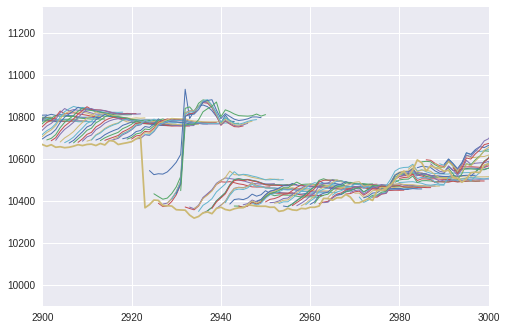

In [208]:
# To Plot the thing half
print(predictions.shape)

for i in range(2600,3000):
  predicted_stock = predictions[i]
  predicted_stock_time = [(i+j) for j in range(len(predicted_stock))]
  plt.plot(predicted_stock_time,predicted_stock,linewidth=1.0)
  
plt.plot(real_stocks)
plt.xlim([2900, 3000])
plt.show()
plt.savefig("9:28pm")

(300, 20)


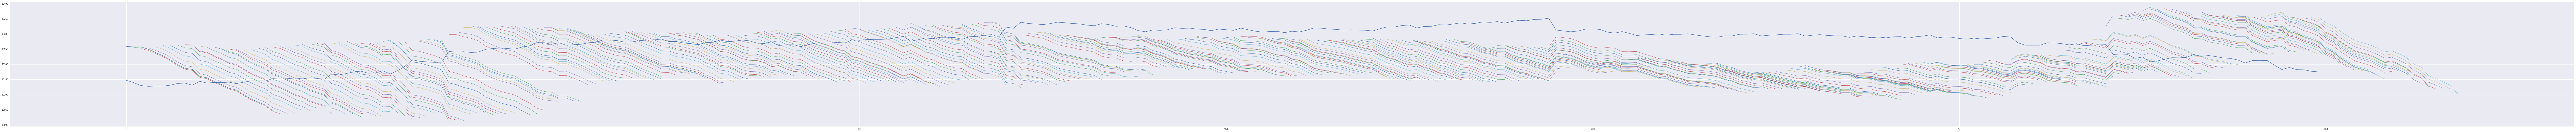

In [14]:
# To Plot the thing full
print(predictions.shape)

plt.figure(figsize = (200,10))
range_size = len(predictions)
for i in range(range_size):
  predicted_stock = predictions[i]
  predicted_stock_time = [(i+j) for j in range(len(predicted_stock))]
  plt.plot(predicted_stock_time,predicted_stock,linewidth=1.0)
  
plt.plot(test_stock[:range_size])
plt.savefig("9:30pm")

In [0]:
files.download("9:30pm.png")

In [202]:
ls 9:30pm.png -l

-rw-r--r-- 1 root root 3412296 Nov  3 16:07 9:30pm.png


In [0]:
plt.show()

In [87]:
model.predict(x_test[0:1,:,:])

array([[0.00270305]], dtype=float32)

In [0]:
window_size = 20
for i in range(len(x_test)):
  
  #curr_frame has the snapshot at time = i
  curr_frame = x_test[i:i+1,:,:]
  #use that single frame to predict the next value
  model.predict(curr_frame)

In [18]:
preditions_.shape

(5579, 1)

In [0]:
real_stocks = predictstock(test_stock, y_test)
predicted_stocks = predictstock(test_stock,preditions_)

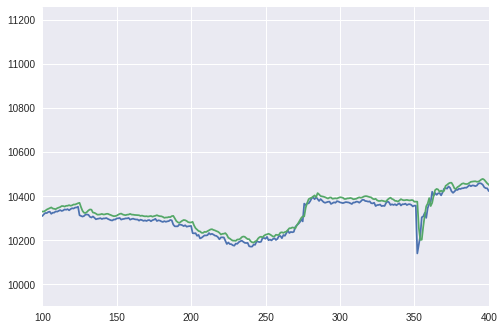

In [93]:
import matplotlib.pyplot as plt
plt.plot(real_stocks)
plt.plot(predicted_stocks)
plt.xlim([100,400])
plt.show()